All Imports

In [127]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import struct
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt

Loading the dataset, Normalizing images, shuffling and resplitting for training, testing and validation.

In [128]:
def load_images(filename):
    with open(filename, 'rb') as f:
        magic, image_count, rowls, cols = struct.unpack(">IIII", f.read(16))
        data = np.frombuffer(f.read(), dtype=np.uint8)
        data = data.reshape((image_count, rowls, cols,1)) # Last dimension is to be compatiable with tensorflow Conv2D input.
        data = data.astype(np.float32) / 255.0  # Normalize to [0, 1]
    return data

def load_labels(filename):
    with open(filename, 'rb') as f:
        magic, label_count = struct.unpack(">II", f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels

def train_test_validation_split(X, Y, random_state,test_ratio=0.15, val_ratio=0.15):
    X_temp, X_test, Y_temp, Y_test = train_test_split(X, Y, test_size=test_ratio, random_state=random_state, stratify=Y)
    val_fraction_temp = val_ratio / (1 - test_ratio)  # Adjust validation size relative to the remaining data
    X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size=val_fraction_temp, random_state=random_state, stratify=Y_temp) # This is done without using mode.fit()s validation split because it's not stratified.
    return X_train, X_test, X_val, Y_train, Y_test, Y_val

# Loading with original split with a reshape.
try:
    init_train_images = load_images('dataset/train-images.idx3-ubyte')
    init_train_labels = load_labels('dataset/train-labels.idx1-ubyte')
    init_test_images = load_images('dataset/t10k-images.idx3-ubyte')
    init_test_labels = load_labels('dataset/t10k-labels.idx1-ubyte')
except Exception as e:
    print("Error loading data. Make sure the data files are present inside a 'dataset' folder with their original names:", e)

# Concatanation before shuffling and resplitting.

X = np.concatenate([init_train_images, init_test_images])
Y = np.concatenate([init_train_labels, init_test_labels])

# Randomisation seed for reproducibility
random_state = 42

# Shuffle and split.
x_train, x_test, x_val, y_train, y_test, y_val = train_test_validation_split(X, Y,random_state)

print(f"Training  Set: {x_train.shape}, {y_train.shape}")
print(f"Test set: {x_test.shape}, {y_test.shape}")
print(f"Validation Set: {x_val.shape}, {y_val.shape}")

Training  Set: (49000, 28, 28, 1), (49000,)
Test set: (10500, 28, 28, 1), (10500,)
Validation Set: (10500, 28, 28, 1), (10500,)


Neural Network Architecture

In [129]:
def get_model():
    model = keras.Sequential([
    layers.Input(shape=(28, 28, 1)),
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(10, activation='softmax')
])
    return model

model = get_model()

Learning Rate, Loss Function and Optimiser Specifications

In [130]:
learning_rate = 0.0005

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_42 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_21 (Flatten)            │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

Learning and early stopping criterion.

In [131]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, min_delta=0.0001)

history = model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), batch_size=512,  callbacks=[early_stopping])

Epoch 1/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - accuracy: 0.7979 - loss: 0.7227 - val_accuracy: 0.9445 - val_loss: 0.1923
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.9498 - loss: 0.1721 - val_accuracy: 0.9653 - val_loss: 0.1134
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - accuracy: 0.9652 - loss: 0.1179 - val_accuracy: 0.9739 - val_loss: 0.0810
Epoch 4/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.9736 - loss: 0.0894 - val_accuracy: 0.9798 - val_loss: 0.0647
Epoch 5/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.9771 - loss: 0.0740 - val_accuracy: 0.9821 - val_loss: 0.0565
Epoch 6/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.9794 - loss: 0.0668 - val_accuracy: 0.9828 - val_loss: 0.0513
Epoch 7/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.9817 - loss: 0.0583 - val_accuracy: 0.9857 - val_loss: 0.0463
Epoch 8/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.9840 - loss: 0.0524 - val_accuracy: 0.9856 - 

Model Evaluation and Performance metrics

In [132]:
# evaluation on the test set.
y_pred = model.predict(x_test).argmax(axis=1)

#performance metrics (precision/recall and F1)
def get_performance_metrics(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted',zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)
    return accuracy, precision, recall, f1

performance = get_performance_metrics(y_test, y_pred)

329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Accuracy: 0.9914285714285714
Precision: 0.9914324225765011
Recall: 0.9914285714285714
F1-score: 0.9914283851775141


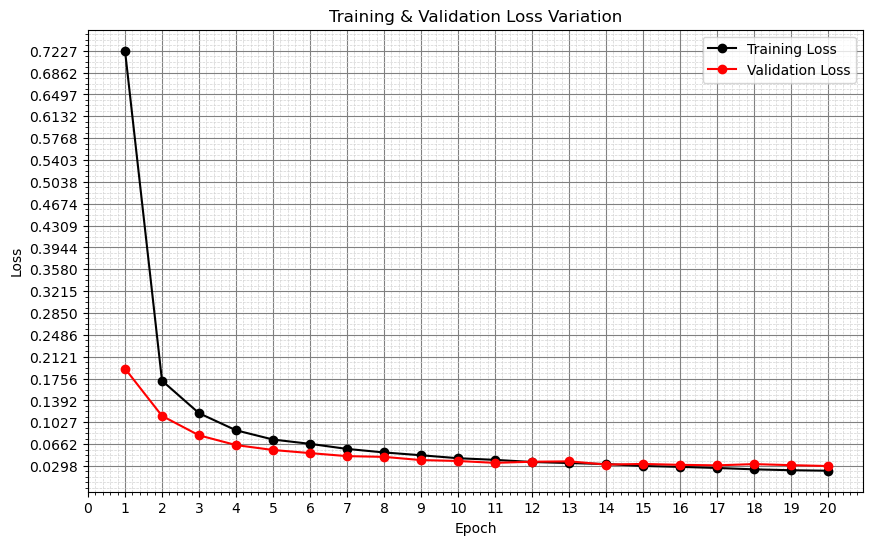

In [133]:

def plot_learning_loss_progression(history):
    plt.figure(figsize=(10, 6))

    # Plot training & validation loss
    epochs = range(1, len(history.history['loss']) + 1) 

    plt.plot(epochs, history.history['loss'], label='Training Loss', linestyle='-', marker='o', color='black')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss', linestyle='-', marker='o', color='red')

    plt.title('Training & Validation Loss Variation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    # making grid and axis more detailed.
    plt.xticks(np.arange(0, len(history.history['loss'])+1, 1))  # one tick per epoch
    plt.yticks(np.linspace(min(history.history['val_loss']), 
                        max(history.history['loss']), 20))  # 20 y-ticks between min & max
    plt.minorticks_on()
    plt.grid(which='major', linestyle='-', linewidth=0.8, color='gray')
    plt.grid(which='minor', linestyle='--', linewidth=0.5, color='lightgray')

    # Legend
    plt.legend()
    plt.show()

plot_learning_loss_progression(history)


#### Training and evaluation of the model with SGD and SGD with momentum for comparision
SGD

In [134]:

model = get_model() # Reinitialize the model
sgd = keras.optimizers.SGD(learning_rate=learning_rate)
model.compile(optimizer=sgd,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

sgd_history = model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), batch_size=512)

Epoch 1/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - accuracy: 0.1238 - loss: 2.2957 - val_accuracy: 0.1508 - val_loss: 2.2912
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.1343 - loss: 2.2899 - val_accuracy: 0.1643 - val_loss: 2.2854
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.1475 - loss: 2.2847 - val_accuracy: 0.1782 - val_loss: 2.2797
Epoch 4/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.1574 - loss: 2.2784 - val_accuracy: 0.1913 - val_loss: 2.2741
Epoch 5/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.1721 - loss: 2.2729 - val_accuracy: 0.2033 - val_loss: 2.2684
Epoch 6/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.1829 - loss: 2.2676 - val_accuracy: 0.2169 - val_loss: 2.2627
Epoch 7/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.1976 - loss: 2.2613 - val_accuracy: 0.2263 - val_loss: 2.2569
Epoch 8/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.2107 - loss: 2.2559 - val_accuracy: 0.2402 - v

329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Accuracy: 0.484
Precision: 0.6010757594612659
Recall: 0.484
F1-score: 0.4644375445270953


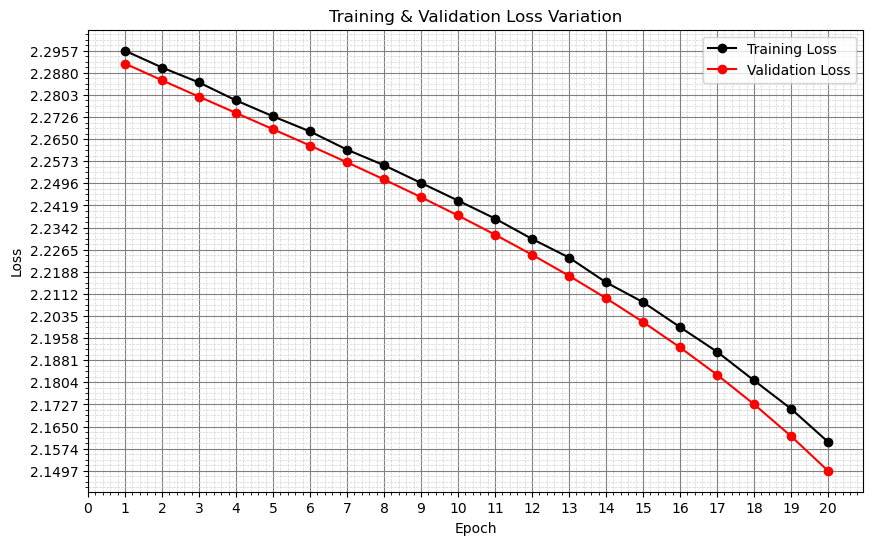

In [135]:
y_pred_sgd = model.predict(x_test).argmax(axis=1)
sgd_performance = get_performance_metrics(y_test, y_pred_sgd)
plot_learning_loss_progression(sgd_history)

SGD+Momentum

In [136]:
model = get_model() # Reinitialize the model
sgd_momentum = keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
model.compile(optimizer=sgd_momentum,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
sgdm_history = model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), batch_size=512)

Epoch 1/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - accuracy: 0.1688 - loss: 2.2733 - val_accuracy: 0.3110 - val_loss: 2.2345
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - accuracy: 0.3303 - loss: 2.1945 - val_accuracy: 0.5152 - val_loss: 2.1355
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.4547 - loss: 2.0563 - val_accuracy: 0.5798 - val_loss: 1.9248
Epoch 4/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.5410 - loss: 1.7633 - val_accuracy: 0.6852 - val_loss: 1.4860
Epoch 5/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.6340 - loss: 1.3231 - val_accuracy: 0.7685 - val_loss: 1.0083
Epoch 6/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.7181 - loss: 0.9758 - val_accuracy: 0.8182 - val_loss: 0.7335
Epoch 7/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - accuracy: 0.7725 - loss: 0.7697 - val_accuracy: 0.8489 - val_loss: 0.5825
Epoch 8/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.8084 - loss: 0.6490 - val_accuracy: 0.8704 - v

329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Accuracy: 0.931047619047619
Precision: 0.9314439156793648
Recall: 0.931047619047619
F1-score: 0.93105046727096


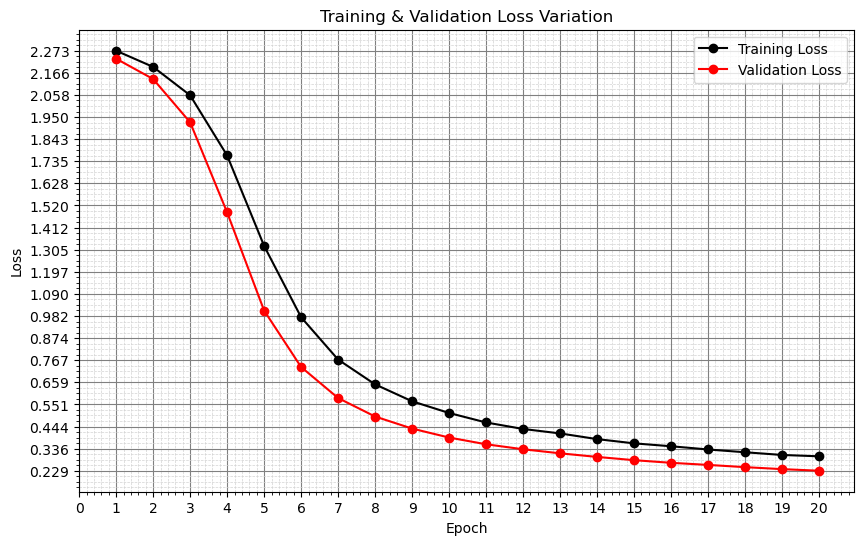

In [137]:
y_pred_sgdm = model.predict(x_test).argmax(axis=1)
sgdm_performance = get_performance_metrics(y_test, y_pred_sgdm)

plot_learning_loss_progression(sgdm_history)